<a href="https://colab.research.google.com/github/hila-chefer/Transformer-MM-Explainability/blob/main/CLIP_explainability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CLIP Explainability**

In [1]:
# !git clone https://github.com/hila-chefer/Transformer-MM-Explainability

import os
# os.chdir(f'./Transformer-MM-Explainability')


!pip install einops
!pip install ftfy
!pip install captum

# **CLIP**

In [2]:
import torch
import CLIP.clip as clip
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
from captum.attr import visualization

In [3]:
import torchvision
from torchvision.utils import draw_bounding_boxes

In [4]:
#@title Control context expansion (number of attention layers to consider)
#@title Number of layers for image Transformer
start_layer =  -1#@param {type:"number"}

#@title Number of layers for text Transformer
start_layer_text =  -1#@param {type:"number"}

In [69]:
image_attn_list = []
text_attn_list = []

In [70]:
cam_list = []

In [7]:
def interpret(image, texts, model, device, start_layer=start_layer, start_layer_text=start_layer_text):
    batch_size = texts.shape[0]
    images = image.repeat(batch_size, 1, 1, 1)
    logits_per_image, logits_per_text = model(images, texts)
    probs = logits_per_image.softmax(dim=-1).detach().cpu().numpy()
    index = [i for i in range(batch_size)]
    one_hot = np.zeros((logits_per_image.shape[0], logits_per_image.shape[1]), dtype=np.float32)
    one_hot[torch.arange(logits_per_image.shape[0]), index] = 1
    one_hot = torch.from_numpy(one_hot).requires_grad_(True)
    one_hot = torch.sum(one_hot.cuda() * logits_per_image)
    model.zero_grad()

    image_attn_blocks = list(dict(model.visual.transformer.resblocks.named_children()).values())

    if start_layer == -1: 
      # calculate index of last layer 
      start_layer = len(image_attn_blocks) - 1
    
    num_tokens = image_attn_blocks[0].attn_probs.shape[-1]
    R = torch.eye(num_tokens, num_tokens, dtype=image_attn_blocks[0].attn_probs.dtype).to(device)
    R = R.unsqueeze(0).expand(batch_size, num_tokens, num_tokens)

    print(len(image_attn_blocks))

    for i, blk in enumerate(image_attn_blocks):
        if i < start_layer:
          continue
        grad = torch.autograd.grad(one_hot, [blk.attn_probs], retain_graph=True)[0].detach()
        cam = blk.attn_probs.detach()
        cam = cam.reshape(-1, cam.shape[-1], cam.shape[-1])
        grad = grad.reshape(-1, grad.shape[-1], grad.shape[-1])
        cam = grad * cam
        cam = cam.reshape(batch_size, -1, cam.shape[-1], cam.shape[-1])

        #remove this and see
        cam = cam.clamp(min=0).mean(dim=1)
        image_attn_list.append(cam)
        # R = R + torch.bmm(cam, R)
    # image_relevance = R[:, 0, 1:]
    image_relevance = cam[:, 0, 1:]


    
    text_attn_blocks = list(dict(model.transformer.resblocks.named_children()).values())

    if start_layer_text == -1: 
      # calculate index of last layer 
      start_layer_text = len(text_attn_blocks) - 1

    num_tokens = text_attn_blocks[0].attn_probs.shape[-1]
    R_text = torch.eye(num_tokens, num_tokens, dtype=text_attn_blocks[0].attn_probs.dtype).to(device)
    R_text = R_text.unsqueeze(0).expand(batch_size, num_tokens, num_tokens)
    for i, blk in enumerate(text_attn_blocks):
        if i < start_layer_text:
          continue
        grad = torch.autograd.grad(one_hot, [blk.attn_probs], retain_graph=True)[0].detach()
        cam = blk.attn_probs.detach()
        cam = cam.reshape(-1, cam.shape[-1], cam.shape[-1])
        grad = grad.reshape(-1, grad.shape[-1], grad.shape[-1])
        cam = grad * cam
        cam = cam.reshape(batch_size, -1, cam.shape[-1], cam.shape[-1])
        cam = cam.clamp(min=0).mean(dim=1)
        text_attn_list.append(cam)
        R_text = R_text + torch.bmm(cam, R_text)
    text_relevance = R_text
   
    return text_relevance, image_relevance

In [8]:
attn_maps_viz = []
orig_img = []

In [9]:
def show_image_relevance(image_relevance, image, orig_image):
    # create heatmap from mask on image
    def show_cam_on_image(img, mask):
        heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
        heatmap = np.float32(heatmap) / 255
        cam = heatmap + np.float32(img)
        cam = cam / np.max(cam)
        return cam

    fig, axs = plt.subplots(1, 2)

    axs[0].imshow(orig_image)
    # orig_img.append(orig_image)
    axs[0].axis('off')

    print(image_relevance.numel())
    dim = int(image_relevance.numel() ** 0.5)
    image_relevance = image_relevance.reshape(1, 1, dim, dim)
    image_relevance = torch.nn.functional.interpolate(image_relevance, size=224, mode='bilinear')
    image_relevance = image_relevance.reshape(224, 224).cuda().data.cpu().numpy()
    image_relevance = (image_relevance - image_relevance.min()) / (image_relevance.max() - image_relevance.min())
    cam_list.append(image_relevance)
    image = image[0].permute(1, 2, 0).data.cpu().numpy()
    image = (image - image.min()) / (image.max() - image.min())
    vis = show_cam_on_image(image, image_relevance)
    vis = np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    attn_maps_viz.append(vis)
    axs[1].imshow(vis)
    axs[1].axis('off')

In [10]:
from CLIP.clip.simple_tokenizer import SimpleTokenizer as _Tokenizer
_tokenizer = _Tokenizer()

def show_heatmap_on_text(text, text_encoding, R_text):
  CLS_idx = text_encoding.argmax(dim=-1)
  R_text = R_text[CLS_idx, 1:CLS_idx]
  text_scores = R_text / R_text.sum()
  text_scores = text_scores.flatten()
  # print(text_scores)
  text_tokens=_tokenizer.encode(text)
  text_tokens_decoded=[_tokenizer.decode([a]) for a in text_tokens]
  vis_data_records = [visualization.VisualizationDataRecord(text_scores,0,0,0,0,0,text_tokens_decoded,1)]
  visualization.visualize_text(vis_data_records)

In [11]:
clip.clip._MODELS = {
    "ViT-B/32": "https://openaipublic.azureedge.net/clip/models/40d365715913c9da98579312b702a82c18be219cc2a73407c4526f58eba950af/ViT-B-32.pt",
    "ViT-B/16": "https://openaipublic.azureedge.net/clip/models/5806e77cd80f8b59890b7e101eabd078d9fb84e6937f9e85e4ecb61988df416f/ViT-B-16.pt",
    "ViT-L/14": "https://openaipublic.azureedge.net/clip/models/b8cca3fd41ae0c99ba7e8951adf17d267cdb84cd88be6f7c2e0eca1737a03836/ViT-L-14.pt",
}

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device, jit=False)

In [13]:
def get_largest_cc_box(mask: np.array):
    from skimage.measure import label as measure_label
    labels = measure_label(mask)  # get connected components
    largest_cc_index = np.argmax(np.bincount(labels.flat)[1:]) + 1
    mask = np.where(labels == largest_cc_index)
    ymin, ymax = min(mask[0]), max(mask[0]) + 1
    xmin, xmax = min(mask[1]), max(mask[1]) + 1
    return [xmin, ymin, xmax, ymax]

In [14]:
def get_bbox_from_patch_mask(patch_mask, init_image_size):

    # Sizing
    H, W = init_image_size[:2]
    T = patch_mask.numel()
    # if (H // 8) * (W // 8) == T:
    #     P, H_lr, W_lr = (8, H // 8, W // 8)
    # elif (H // 16) * (W // 16) == T:
    #     P, H_lr, W_lr = (16, H // 16, W // 16)
    # elif 4 * (H // 16) * (W // 16) == T:
    #     P, H_lr, W_lr = (8, 2 * (H // 16), 2 * (W // 16))
    # elif 16 * (H // 32) * (W // 32) == T:
    #     P, H_lr, W_lr = (8, 4 * (H // 32), 4 * (W // 32))
    # else:
    #     raise ValueError(f'{init_image_size=}, {patch_mask.shape=}')
    P = 1
    H_lr = 224
    W_lr = 224

    # # Create patch mask
    patch_mask = patch_mask.reshape(H_lr, W_lr).cpu().numpy()
    # patch_mask = patch_mask.cpu().numpy() 

    # Possibly reverse mask
    # print(np.mean(patch_mask).item())
    if 0.5 < np.mean(patch_mask).item() < 1.0:
        patch_mask = (1 - patch_mask).astype(np.uint8)
    elif np.sum(patch_mask).item() == 0:  # nothing detected at all, so cover the entire image
        patch_mask = (1 - patch_mask).astype(np.uint8)

    # Get the box corresponding to the largest connected component of the first eigenvector
    xmin, ymin, xmax, ymax = get_largest_cc_box(patch_mask)
    # pred = [xmin, ymin, xmax, ymax]

    # Rescale to image size
    r_xmin, r_xmax = P * xmin, P * xmax
    r_ymin, r_ymax = P * ymin, P * ymax

    # Prediction bounding box
    pred = [r_xmin, r_ymin, r_xmax, r_ymax]

    # Check not out of image size (used when padding)
    pred[2] = min(pred[2], W)
    pred[3] = min(pred[3], H)

    return np.asarray(pred)

In [15]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

12


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,a man with eye glasses


49


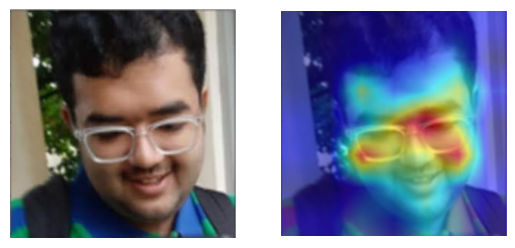

In [16]:
# img_path = "CLIP/glasses.png"
img_path = "../../weird_dj.png"

init_image_size = cv2.imread(img_path).shape
img = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
texts = ["a man with eyeglasses"]
text = clip.tokenize(texts).to(device)

R_text, R_image = interpret(model=model, image=img, texts=text, device=device)
batch_size = text.shape[0]
for i in range(batch_size):
  show_heatmap_on_text(texts[i], text[i], R_text[i])
  show_image_relevance(R_image[i], img, orig_image=Image.open(img_path))
  plt.show()

In [71]:
cv2.imwrite('attn_map.jpg', attn_maps_viz[0])

True

In [86]:
def get_bbox_img (img_path, attn_map):
    test_bin = np.where(attn_map > 127, 0, 255)
    img_size = test_bin.shape[0]
    xmin, xmax, ymin, ymax = 0, 0, 0, 0

    for i in range(img_size):
        if sum(test_bin[i]) < img_size*255:
            ymax = i
            break

    for i in range(img_size):
        if sum(test_bin[-i]) < img_size*255:
            ymin = img_size - i
            break

    for i in range(img_size):
        if sum(test_bin[:, i]) < img_size*255:
            xmin = i
            break

    for i in range(img_size):
        if sum(test_bin[:, -i]) < img_size*255:
            xmax = img_size - i
            break

    img1 = cv2.imread(img_path)
    img1 = cv2.resize(img1, (224, 224))
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

    final = cv2.rectangle(img1, (xmin, ymax), (xmax, ymin), (255, 255, 0), 2)

    return final
    

In [87]:
y1 = cv2.imread('y1.png')

In [88]:
# img1 = cv2.imread(img_path)
img1 = cv2.resize(y1, (224, 224))
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

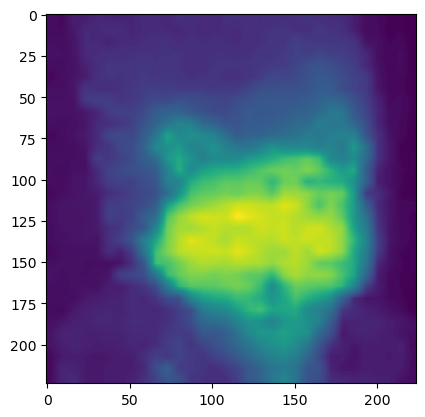

In [92]:
plt.imshow(img1)

In [89]:
# final = get_bbox_img(img_path, cam_list[0])
final = get_bbox_img(img_path, img1)


In [90]:
# y1

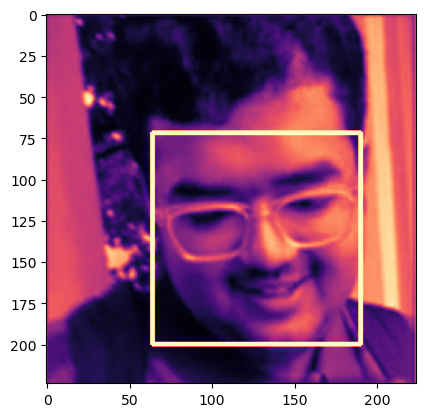

In [91]:
plt.imshow(final, cmap = 'magma')
# cv2.resize(np.array(orig_img[0]), (224, 224))

In [38]:
# img = cv2.cvtColor(cam_list[0], cv2.COLOR_BGR2GRAY)
# ret, thresh1 = cv2.threshold(img, 120, 255, cv2.THRESH_BINARY)
# plt.imshow(test_bin, cmap = 'gray')


In [21]:
# final_cam = cam_list[1][0]
# for head in range(1, cam_list[1].shape[0]):
#     final_cam += cam_list[1][head]

# # plt.imshow(torch.matmul(final_cam, torch.transpose(final_cam, 0, 1)).cpu())
# # plt.imshow(cam_list[1][5].cpu())

# # cam_list[1].shape
# # plt.imshow(cam_list[1][0].cpu())
# cam_list[1].shape


In [22]:
# cv2.imwrite('test.jpg', attn_maps_viz[0])

In [23]:
# y1 = cv2.imread('ev1.png')
# y1 = cv2.resize(y1, (224, 224))
# y1.shape

In [24]:
# plt.imshow(attn_maps_viz[0])
device

'cuda'

In [156]:
image_attn_list[0].shape

torch.Size([1, 50, 50])

In [ ]:
### padding t_i
final_attn_map = torch.tensor(cam_list[0]).to(device)
# final_attn_map = image_attn_list[0].to(device)[0]

# print(final_attn_map.shape)
# print(final_attn_map.shape)
# W = torch.reshape(final_attn_map[:, :, 0], (final_attn_map.shape[0], final_attn_map.shape[1]))
# W = torch.matmul( final_attn_map[:, :, 0], torch.transpose(final_attn_map, 0, 1)[:, :, 0] )
# W = torch.where(W > 0, W, 0)
W = torch.matmul( final_attn_map, torch.transpose(final_attn_map, 0, 1) ) 
W = torch.where(final_attn_map > 0.05, 1, 0)

print(W.shape)

D = torch.zeros(W.shape[0], W.shape[1]).to(device)
for i in range(D.shape[0]):
  D[i, i] = torch.sum(W[i])

# L = torch.matmul( torch.matmul(torch.pow(D, -1/2), (D - W)), torch.pow(D, -1/2) )
# L = torch.matmul( torch.matmul( D ** 0.5, (D - W) ), D ** 0.5 )
L = D - W
# # L = W 

eig_vals, eig_vecs = torch.linalg.eig(L)
eig_vals = eig_vals.real
eig_vecs = eig_vecs.real

result, indices = torch.sort(eig_vals, descending=False)
# evecs = eig_vecs @ torch.diag(L) @ torch.linalg.inv(eig_vecs)

print(result, indices)

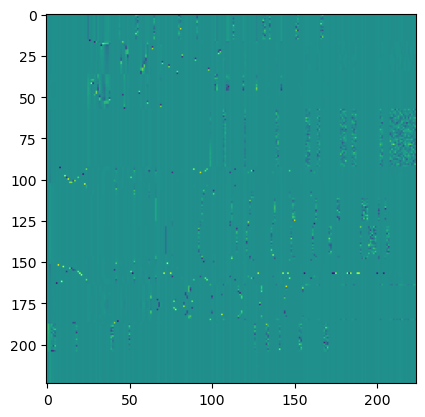

In [200]:
plt.imshow(eig_vecs.cpu())

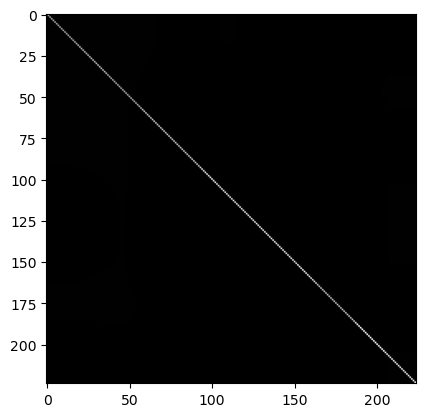

In [195]:
plt.imshow(L.cpu(), cmap = 'gray')

In [197]:
W[126]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')

In [193]:
D[0]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')

In [139]:
eig_vecs[:, 1].shape
eig_vecs.shape

torch.Size([224, 224])

In [140]:
y1 = torch.cat( (eig_vecs[:, 1], torch.zeros(1).to(device)), 0).reshape(1, 1, 15, 15)
# print(y1.shape)
y1 = torch.nn.functional.interpolate(y1, size=15, mode='bilinear')
y1 = y1.reshape(15, 15)


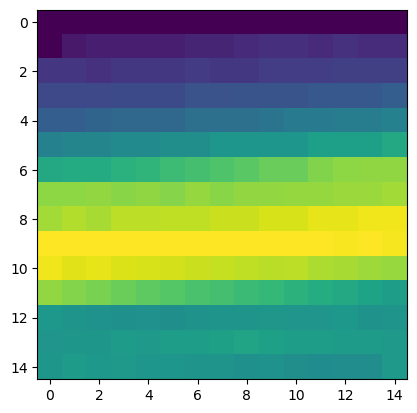

In [141]:
plt.imshow(y1.real.cpu())


In [58]:
y1.shape

torch.Size([1, 1, 224, 1])

In [59]:
# torch.matmul(torch.transpose(W[0].unsqueeze(0), 0, 1), W[0].unsqueeze(0))
# plt.imshow( torch.where(eig_vecs > 0, eig_vecs, 0) )

In [152]:
# plt.imshow(torch.matmul(torch.transpose(W[0].unsqueeze(0), 0, 1), W[0].unsqueeze(0)).cpu())

In [118]:
# for i in range(batch_size):
#   show_heatmap_on_text(texts[i], text[i], R_text[i])
#   show_image_relevance(eig_vecs[2][i], img, orig_image=Image.open(img_path))
#   plt.show()

In [119]:
# y1 = torch.tensor(y1[:, :, 0])
# y1 = torch.where( y1 > 0, y1, 0 )

In [120]:
# plt.imshow(y1)

In [75]:
# bboxes = get_bbox_from_patch_mask(y1, (224, 224, 3))

In [76]:
# bboxes

array([156,   0, 224, 224], dtype=int64)

In [49]:
# bboxes = torch.tensor(bboxes, dtype=torch.int).unsqueeze(0)

In [50]:
# bboxes.shape

torch.Size([1, 4])

In [51]:
# torch.tensor(attn_maps_viz[0]).shape

torch.Size([224, 224, 3])

In [52]:
# bboxes[:, 0]

tensor([156], dtype=torch.int32)

In [66]:
# np.array(orig_img[0]).shape

(105, 107, 3)

In [67]:
img = draw_bounding_boxes(torch.tensor(np.transpose(attn_maps_viz[0])), bboxes, width=5,
                          colors="green", 
                          fill=True)

# img = draw_bounding_boxes(torch.tensor(np.transpose(orig_img)), bboxes, width=5,
#                           colors="green", 
#                           fill=True)

img = torchvision.transforms.ToPILImage()(img)
  
# display output
img.show()

12


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,a man with lipstick


49


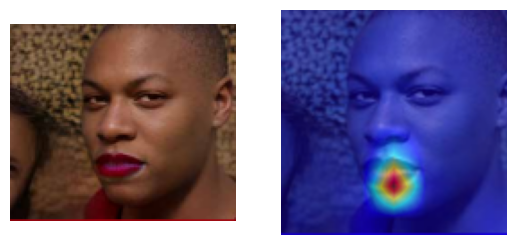

In [113]:
img_path = "CLIP/lipstick.png"
img = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
texts = ["a man with lipstick"]
text = clip.tokenize(texts).to(device)

R_text, R_image = interpret(model=model, image=img, texts=text, device=device)
batch_size = text.shape[0]
for i in range(batch_size):
  show_heatmap_on_text(texts[i], text[i], R_text[i])
  show_image_relevance(R_image[i], img, orig_image=Image.open(img_path))
  plt.show()

12
tensor([0.0080, 0.0203, 0.1851, 0.0994, 0.0069, 0.0962, 0.5840],
       device='cuda:0', dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,a rocket standing on a launch pad


49


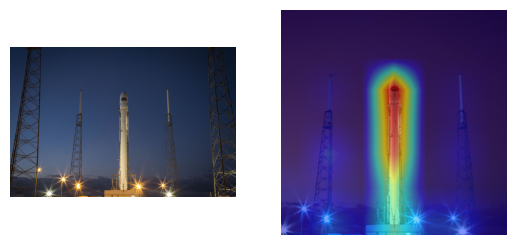

In [87]:
img_path = "CLIP/rocket.jpg"
img = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
texts = ["a rocket standing on a launchpad"]
text = clip.tokenize(texts).to(device)

R_text, R_image = interpret(model=model, image=img, texts=text, device=device)
batch_size = text.shape[0]
for i in range(batch_size):
  show_heatmap_on_text(texts[i], text[i], R_text[i])
  show_image_relevance(R_image[i], img, orig_image=Image.open(img_path))
  plt.show()

tensor([0.0204, 0.9800], device='cuda:0', dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,a zebra


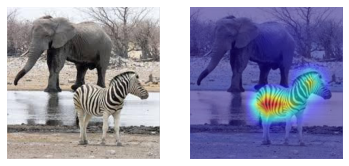

tensor([0.0355, 0.9644], device='cuda:0', dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,an elephant


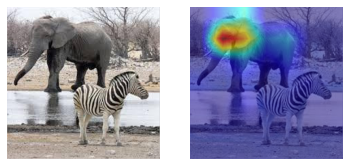

tensor([0.5366, 0.4634], device='cuda:0', dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,a lake


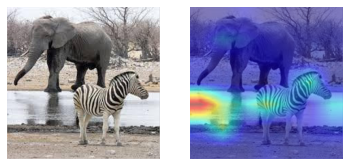

In [40]:
img_path = "CLIP/el2.png"
img = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
texts = ['a zebra', 'an elephant', 'a lake']
text = clip.tokenize(texts).to(device)

R_text, R_image = interpret(model=model, image=img, texts=text, device=device)
batch_size = text.shape[0]
for i in range(batch_size):
  show_heatmap_on_text(texts[i], text[i], R_text[i])
  show_image_relevance(R_image[i], img, orig_image=Image.open(img_path))
  plt.show()

tensor([0.1194, 0.8804], device='cuda:0', dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,a zebra


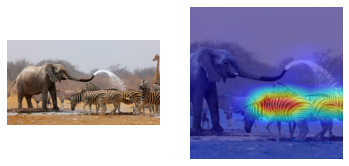

tensor([0.0837, 0.9165], device='cuda:0', dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,an elephant


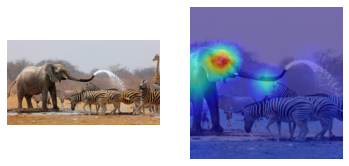

tensor([1.], device='cuda:0', dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,water


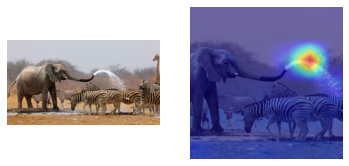

In [41]:
img_path = "CLIP/el3.png"
img = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
texts = ['a zebra', 'an elephant', 'water']
text = clip.tokenize(texts).to(device)

R_text, R_image = interpret(model=model, image=img, texts=text, device=device)
batch_size = text.shape[0]
for i in range(batch_size):
  show_heatmap_on_text(texts[i], text[i], R_text[i])
  show_image_relevance(R_image[i], img, orig_image=Image.open(img_path))
  plt.show()

tensor([0.0371, 0.9629], device='cuda:0', dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,an elephant


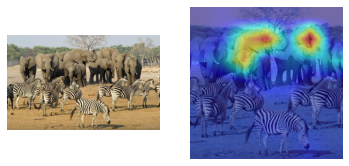

tensor([0.0189, 0.9810], device='cuda:0', dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,a zebra


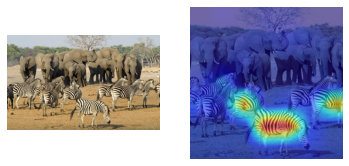

In [42]:
img_path = "CLIP/el4.png"
img = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
texts = ['an elephant', 'a zebra']
text = clip.tokenize(texts).to(device)

R_text, R_image = interpret(model=model, image=img, texts=text, device=device)
batch_size = text.shape[0]
for i in range(batch_size):
  show_heatmap_on_text(texts[i], text[i], R_text[i])
  show_image_relevance(R_image[i], img, orig_image=Image.open(img_path))
  plt.show()

tensor([0.0445, 0.9556], device='cuda:0', dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,an elephant


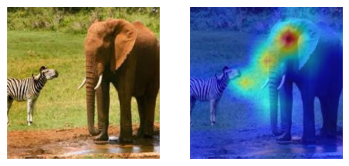

tensor([0.0583, 0.9419], device='cuda:0', dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,a zebra


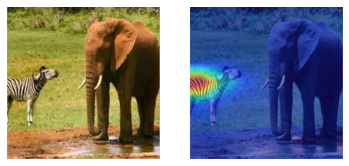

In [43]:
img_path = "CLIP/el1.png"
img = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
texts = ['an elephant', 'a zebra']
text = clip.tokenize(texts).to(device)

R_text, R_image = interpret(model=model, image=img, texts=text, device=device)
batch_size = text.shape[0]
for i in range(batch_size):
  show_heatmap_on_text(texts[i], text[i], R_text[i])
  show_image_relevance(R_image[i], img, orig_image=Image.open(img_path))
  plt.show()

tensor([0.0452, 0.9551], device='cuda:0', dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,a dog


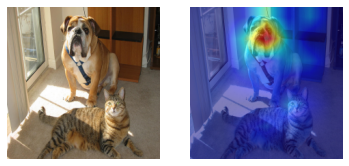

tensor([0.0349, 0.9653], device='cuda:0', dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,a cat


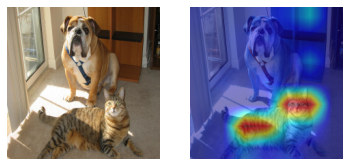

In [44]:
img_path = "CLIP/catdog.png"
img = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
texts = ["a dog", "a cat"]
text = clip.tokenize(texts).to(device)

R_text, R_image = interpret(model=model, image=img, texts=text, device=device)
batch_size = text.shape[0]
for i in range(batch_size):
  show_heatmap_on_text(texts[i], text[i], R_text[i])
  show_image_relevance(R_image[i], img, orig_image=Image.open(img_path))
  plt.show()

tensor([0.0237, 0.9761], device='cuda:0', dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,a labrador


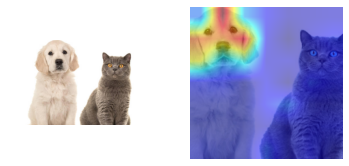

tensor([0.0448, 0.5820, 0.3730], device='cuda:0', dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,a tabby cat


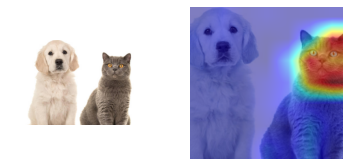

In [45]:
img_path = "CLIP/dogcat2.png"
img = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
texts = ["a labrador", "a tabby cat"]
text = clip.tokenize(texts).to(device)

R_text, R_image = interpret(model=model, image=img, texts=text, device=device)
batch_size = text.shape[0]
for i in range(batch_size):
  show_heatmap_on_text(texts[i], text[i], R_text[i])
  show_image_relevance(R_image[i], img, orig_image=Image.open(img_path))
  plt.show()

tensor([0.1221, 0.8774], device='cuda:0', dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,a parrot


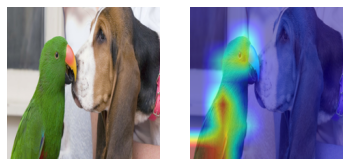

tensor([0.2527, 0.7476], device='cuda:0', dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,a dog


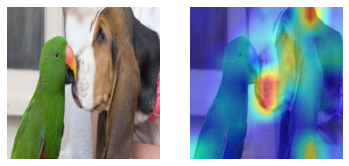

In [46]:
img_path = "CLIP/dogbird.png"
img = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
texts = ["a parrot", "a dog"]
text = clip.tokenize(texts).to(device)

R_text, R_image = interpret(model=model, image=img, texts=text, device=device)
batch_size = text.shape[0]
for i in range(batch_size):
  show_heatmap_on_text(texts[i], text[i], R_text[i])
  show_image_relevance(R_image[i], img, orig_image=Image.open(img_path))
  plt.show()

tensor([0.0724, 0.1284, 0.0591, 0.0404, 0.6997], device='cuda:0',
       dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,a portrait of an astronaut


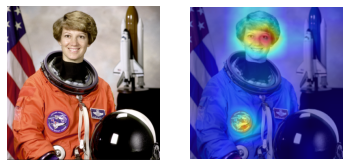

tensor([0.5361, 0.4641], device='cuda:0', dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,a rocket


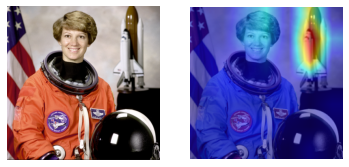

tensor([0.2217, 0.6353, 0.1434], device='cuda:0', dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,an astronaut suit


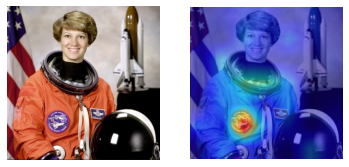

In [47]:
img_path = "CLIP/astronaut.png"
img = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
texts = ["a portrait of an astronaut", "a rocket", "an astronaut suit"]
text = clip.tokenize(texts).to(device)

R_text, R_image = interpret(model=model, image=img, texts=text, device=device)
batch_size = text.shape[0]
for i in range(batch_size):
  show_heatmap_on_text(texts[i], text[i], R_text[i])
  show_image_relevance(R_image[i], img, orig_image=Image.open(img_path))
  plt.show()

# Examples of biased similarity scores (noise scores higher than dog)

CLIP similarity score: 26.96875
tensor([0.0317, 0.3079, 0.0706, 0.0163, 0.5732], device='cuda:0',
       dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,an image of a dog


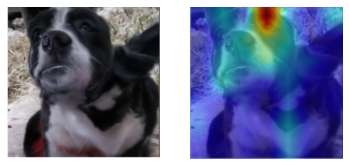

In [48]:
img_path = "CLIP/dog.png"
img = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
texts = ["an image of a dog"]
text = clip.tokenize(texts).to(device)
logits_per_image, logits_per_text = model(img, text)
print(color.BOLD + color.PURPLE + color.UNDERLINE + f'CLIP similarity score: {logits_per_image.item()}' + color.END)
R_text, R_image = interpret(model=model, image=img, texts=text, device=device)
batch_size = text.shape[0]
for i in range(batch_size):
  show_heatmap_on_text(texts[i], text[i], R_text[i])
  show_image_relevance(R_image[i], img, orig_image=Image.open(img_path))
  plt.show()

CLIP similarity score: 28.71875
tensor([0.0592, 0.3030, 0.4734, 0.0612, 0.1031], device='cuda:0',
       dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,an image of a dog


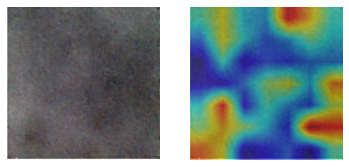

In [49]:
img_path = "CLIP/noise.png"
img = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
texts = ["an image of a dog"]
text = clip.tokenize(texts).to(device)
logits_per_image, logits_per_text = model(img, text)
print(color.BOLD + color.PURPLE + color.UNDERLINE + f'CLIP similarity score: {logits_per_image.item()}' + color.END)
R_text, R_image = interpret(model=model, image=img, texts=text, device=device)
batch_size = text.shape[0]
for i in range(batch_size):
  show_heatmap_on_text(texts[i], text[i], R_text[i])
  show_image_relevance(R_image[i], img, orig_image=Image.open(img_path))
  plt.show()